In [1]:
%matplotlib inline

import os
import sys
import math
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import invisible_cities.reco.dst_functions as dstf

from   invisible_cities.database               import load_db
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.io.dst_io              import load_dst

import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d

In [15]:
## style
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   
    
blue = tableau20[0]
green = tableau20[4]
red = tableau20[6]
pink = tableau20[7]
purple = tableau20[8]
light_purple = tableau20[9]
brown = tableau20[10]
grey = tableau20[15]

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = 12, 8

In [4]:
## functions to fit
def twogauss(x, amp0, mu0, sigma0, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def threegauss(x, amp0, mu0, sigma0, amp1, mu1, sigma1, amp, mu, sigma):
    return  amp0/(2*np.pi)**.5/sigma0 * np.exp(-0.5*(x-mu0)**2./sigma0**2.) + amp1/(2*np.pi)**.5/sigma1 * np.exp(-0.5*(x-mu1)**2./sigma1**2.) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def gauss(x, amp, mu, sigma):
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)

def exp(x, a0, tau):
    return a0 * np.exp(x/tau) 

def expgauss(x, a0, tau, amp, mu, sigma):
    return a0 * np.exp(x/tau) + amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.)



In [17]:
import textwrap
from invisible_cities.evm.ic_containers   import Measurement
from invisible_cities.icaro.hst_functions import measurement_string

def gtext(values, errors):
    """
    Build a string to be displayed within a matplotlib plot.
    """
    return textwrap.dedent("""
        $\mu$ = {0}
        $\sigma$ = {1}
        res = {2}
        """.format(measurement_string(values[0] , errors[0]),
                                  measurement_string(values[1] , errors[1]), 2.35*values[1]))

In [5]:
true_x1 = true_x2 = true_y1 = true_y2 = true_z1 = true_z2 = []
reco_x1 = reco_x2 = reco_y1 = reco_y2 = reco_z1 = reco_z2 = []
events = []
#reco_x1_int = reco_x2_int = reco_y1_int = reco_y2_int = reco_z1_int = reco_z2_int = []
#reco_x1_ext = reco_x2_ext = reco_y1_ext = reco_y2_ext = reco_z1_ext = reco_z2_ext = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/'
filenames = ['full_ring_depth3cm_pitch4mm_phot_reco_{0}_{1}_0.npz']
#filenames = ['full_ring_depth3cm_pitch4mm_phot_reco_{0}_{1}_0.npz', 
#             'full_ring_depth3cm_pitch4mm_phot_reco_int_{0}_{1}_0.npz', 
#             'full_ring_depth3cm_pitch4mm_phot_reco_ext_{0}_{1}_0.npz']

bunch = 1
for f in range(0, 70, bunch):
    for i, fn in enumerate(filenames, start=0):
        filename = file_base + fn.format(f, bunch)
        try:
            d = np.load(filename)
        except:
            print('File {} not found'.format(filename))
            continue 
            
        #print('Loading {}'.format(filename))
        if i == 0:
            true_x1 = np.concatenate((true_x1, d['a_true_x1']))
            true_y1 = np.concatenate((true_y1, d['a_true_y1']))
            true_z1 = np.concatenate((true_z1, d['a_true_z1']))   
            true_x2 = np.concatenate((true_x2, d['a_true_x2']))
            true_y2 = np.concatenate((true_y2, d['a_true_y2']))
            true_z2 = np.concatenate((true_z2, d['a_true_z2']))
            
            reco_x1 = np.concatenate((reco_x1, d['a_reco_x1']))
            reco_y1 = np.concatenate((reco_y1, d['a_reco_y1']))
            reco_z1 = np.concatenate((reco_z1, d['a_reco_z1']))   
            reco_x2 = np.concatenate((reco_x2, d['a_reco_x2']))
            reco_y2 = np.concatenate((reco_y2, d['a_reco_y2']))
            reco_z2 = np.concatenate((reco_z2, d['a_reco_z2']))
            
            events = np.concatenate((events, d['a_events']))
        
        if i == 1:            
            reco_x1_int = np.concatenate((reco_x1_int, d['a_reco_x1']))
            reco_y1_int = np.concatenate((reco_y1_int, d['a_reco_y1']))
            reco_z1_int = np.concatenate((reco_z1_int, d['a_reco_z1']))   
            reco_x2_int = np.concatenate((reco_x2_int, d['a_reco_x2']))
            reco_y2_int = np.concatenate((reco_y2_int, d['a_reco_y2']))
            reco_z2_int = np.concatenate((reco_z2_int, d['a_reco_z2'])) 
            
        if i == 2:
            reco_x1_ext = np.concatenate((reco_x1_ext, d['a_reco_x1']))
            reco_y1_ext = np.concatenate((reco_y1_ext, d['a_reco_y1']))
            reco_z1_ext = np.concatenate((reco_z1_ext, d['a_reco_z1']))   
            reco_x2_ext = np.concatenate((reco_x2_ext, d['a_reco_x2']))
            reco_y2_ext = np.concatenate((reco_y2_ext, d['a_reco_y2']))
            reco_z2_ext = np.concatenate((reco_z2_ext, d['a_reco_z2'])) 
            
            
true_x1 = np.array(true_x1)
true_x2 = np.array(true_x2)
true_y1 = np.array(true_y1)
true_y2 = np.array(true_y2)
true_z1 = np.array(true_z1)
true_z2 = np.array(true_z2)


reco_x1 = np.array(reco_x1)
reco_x2 = np.array(reco_x2)
reco_y1 = np.array(reco_y1)
reco_y2 = np.array(reco_y2)
reco_z1 = np.array(reco_z1)
reco_z2 = np.array(reco_z2)

events = np.array(events)

In [8]:
true_x1_thr2 = true_x2_thr2 = true_y1_thr2 = true_y2_thr2 = true_z1_thr2 = true_z2_thr2 = []
reco_x1_thr2 = reco_x2_thr2 = reco_y1_thr2 = reco_y2_thr2 = reco_z1_thr2 = reco_z2_thr2 = []
events_thr2 = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch4mm_phot_reco_{0}_{1}_2.npz'

bunch = 1
for f in range(0, 70, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
            
    true_x1_thr2 = np.concatenate((true_x1_thr2, d['a_true_x1']))
    true_y1_thr2 = np.concatenate((true_y1_thr2, d['a_true_y1']))
    true_z1_thr2 = np.concatenate((true_z1_thr2, d['a_true_z1']))   
    true_x2_thr2 = np.concatenate((true_x2_thr2, d['a_true_x2']))
    true_y2_thr2 = np.concatenate((true_y2_thr2, d['a_true_y2']))
    true_z2_thr2 = np.concatenate((true_z2_thr2, d['a_true_z2']))
            
    reco_x1_thr2 = np.concatenate((reco_x1_thr2, d['a_reco_x1']))
    reco_y1_thr2 = np.concatenate((reco_y1_thr2, d['a_reco_y1']))
    reco_z1_thr2 = np.concatenate((reco_z1_thr2, d['a_reco_z1']))   
    reco_x2_thr2 = np.concatenate((reco_x2_thr2, d['a_reco_x2']))
    reco_y2_thr2 = np.concatenate((reco_y2_thr2, d['a_reco_y2']))
    reco_z2_thr2 = np.concatenate((reco_z2_thr2, d['a_reco_z2']))
    
    events_thr2 = np.concatenate((events_thr2, d['a_events']))
    
true_x1_thr2 = np.array(true_x1_thr2)
true_x2_thr2 = np.array(true_x2_thr2)
true_y1_thr2 = np.array(true_y1_thr2)
true_y2_thr2 = np.array(true_y2_thr2)
true_z1_thr2 = np.array(true_z1_thr2)
true_z2_thr2 = np.array(true_z2_thr2)


reco_x1_thr2 = np.array(reco_x1_thr2)
reco_x2_thr2 = np.array(reco_x2_thr2)
reco_y1_thr2 = np.array(reco_y1_thr2)
reco_y2_thr2 = np.array(reco_y2_thr2)
reco_z1_thr2 = np.array(reco_z1_thr2)
reco_z2_thr2 = np.array(reco_z2_thr2)

events_thr2 = np.array(events_thr2)

In [15]:
true_x1_thr2_6mm = true_x2_thr2_6mm = true_y1_thr2_6mm = true_y2_thr2_6mm = true_z1_thr2_6mm = true_z2_thr2_6mm = []
reco_x1_thr2_6mm = reco_x2_thr2_6mm = reco_y1_thr2_6mm = reco_y2_thr2_6mm = reco_z1_thr2_6mm = reco_z2_thr2_6mm = []
events_thr2_6mm = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_{0}_{1}_2.npz'

bunch = 1
for f in range(0, 70, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
          
    print('Loading {}'.format(filename))
    true_x1_thr2_6mm = np.concatenate((true_x1_thr2_6mm, d['a_true_x1']))
    true_y1_thr2_6mm = np.concatenate((true_y1_thr2_6mm, d['a_true_y1']))
    true_z1_thr2_6mm = np.concatenate((true_z1_thr2_6mm, d['a_true_z1']))   
    true_x2_thr2_6mm = np.concatenate((true_x2_thr2_6mm, d['a_true_x2']))
    true_y2_thr2_6mm = np.concatenate((true_y2_thr2_6mm, d['a_true_y2']))
    true_z2_thr2_6mm = np.concatenate((true_z2_thr2_6mm, d['a_true_z2']))
            
    reco_x1_thr2_6mm = np.concatenate((reco_x1_thr2_6mm, d['a_reco_x1']))
    reco_y1_thr2_6mm = np.concatenate((reco_y1_thr2_6mm, d['a_reco_y1']))
    reco_z1_thr2_6mm = np.concatenate((reco_z1_thr2_6mm, d['a_reco_z1']))   
    reco_x2_thr2_6mm = np.concatenate((reco_x2_thr2_6mm, d['a_reco_x2']))
    reco_y2_thr2_6mm = np.concatenate((reco_y2_thr2_6mm, d['a_reco_y2']))
    reco_z2_thr2_6mm = np.concatenate((reco_z2_thr2_6mm, d['a_reco_z2']))
    
    events_thr2_6mm = np.concatenate((events_thr2_6mm, d['a_events']))
    
    
true_x1_thr2_6mm = np.array(true_x1_thr2_6mm)
true_x2_thr2_6mm = np.array(true_x2_thr2_6mm)
true_y1_thr2_6mm = np.array(true_y1_thr2_6mm)
true_y2_thr2_6mm = np.array(true_y2_thr2_6mm)
true_z1_thr2_6mm = np.array(true_z1_thr2_6mm)
true_z2_thr2_6mm = np.array(true_z2_thr2_6mm)


reco_x1_thr2_6mm = np.array(reco_x1_thr2_6mm)
reco_x2_thr2_6mm = np.array(reco_x2_thr2_6mm)
reco_y1_thr2_6mm = np.array(reco_y1_thr2_6mm)
reco_y2_thr2_6mm = np.array(reco_y2_thr2_6mm)
reco_z1_thr2_6mm = np.array(reco_z1_thr2_6mm)
reco_z2_thr2_6mm = np.array(reco_z2_thr2_6mm)

events_thr2_6mm = np.array(events_thr2_6mm)

File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_0_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_1_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_2_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_3_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_4_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_5_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_6_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch6mm_phot_reco_7_1_2.npz not found
File /Users/paola/PETALO/analysis/observables/photoelect

In [9]:
true_x1_thr3 = true_x2_thr3 = true_y1_thr3 = true_y2_thr3 = true_z1_thr3 = true_z2_thr3 = []
reco_x1_thr3 = reco_x2_thr3 = reco_y1_thr3 = reco_y2_thr3 = reco_z1_thr3 = reco_z2_thr3 = []
events_thr3 = []

file_base = '/Users/paola/PETALO/analysis/observables/photoelectric/full_ring_depth3cm_pitch4mm_phot_reco_{0}_{1}_3.npz'

bunch = 1
for f in range(0, 70, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
            
    true_x1_thr3 = np.concatenate((true_x1_thr3, d['a_true_x1']))
    true_y1_thr3 = np.concatenate((true_y1_thr3, d['a_true_y1']))
    true_z1_thr3 = np.concatenate((true_z1_thr3, d['a_true_z1']))   
    true_x2_thr3 = np.concatenate((true_x2_thr3, d['a_true_x2']))
    true_y2_thr3 = np.concatenate((true_y2_thr3, d['a_true_y2']))
    true_z2_thr3 = np.concatenate((true_z2_thr3, d['a_true_z2']))
            
    reco_x1_thr3 = np.concatenate((reco_x1_thr3, d['a_reco_x1']))
    reco_y1_thr3 = np.concatenate((reco_y1_thr3, d['a_reco_y1']))
    reco_z1_thr3 = np.concatenate((reco_z1_thr3, d['a_reco_z1']))   
    reco_x2_thr3 = np.concatenate((reco_x2_thr3, d['a_reco_x2']))
    reco_y2_thr3 = np.concatenate((reco_y2_thr3, d['a_reco_y2']))
    reco_z2_thr3 = np.concatenate((reco_z2_thr3, d['a_reco_z2']))
    
    events_thr3 = np.concatenate((events_thr3, d['a_events']))
    
true_x1_thr3 = np.array(true_x1_thr3)
true_x2_thr3 = np.array(true_x2_thr3)
true_y1_thr3 = np.array(true_y1_thr3)
true_y2_thr3 = np.array(true_y2_thr3)
true_z1_thr3 = np.array(true_z1_thr3)
true_z2_thr3 = np.array(true_z2_thr3)


reco_x1_thr3 = np.array(reco_x1_thr3)
reco_x2_thr3 = np.array(reco_x2_thr3)
reco_y1_thr3 = np.array(reco_y1_thr3)
reco_y2_thr3 = np.array(reco_y2_thr3)
reco_z1_thr3 = np.array(reco_z1_thr3)
reco_z2_thr3 = np.array(reco_z2_thr3)

events_thr3 = np.array(events_thr3)


In [20]:
len(true_x1_thr3)

450387

### Using both SiPMs, comparing thresholds

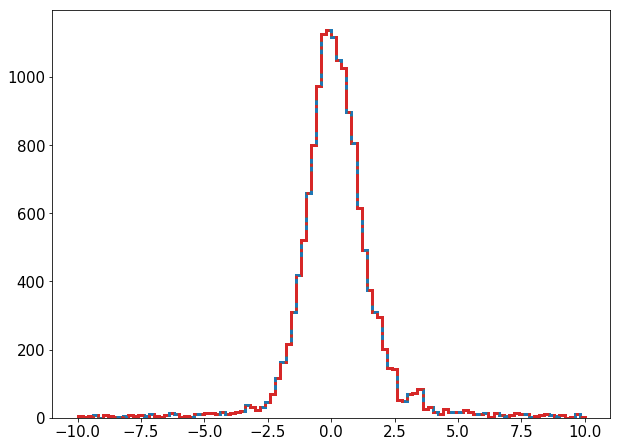

In [24]:
colors = [blue, green, red, purple, brown]
linestyle = ['-', '-.', ':','-','--']

### Threshold = 0
valid1 = reco_x1 < 1.e9
valid2 = reco_x2 < 1.e9

rad_true1 = np.sqrt(true_x1 * true_x1 + true_y1 * true_y1) 
rad_reco1 = np.sqrt(reco_x1 * reco_x1 + reco_y1 * reco_y1)
rad_true2 = np.sqrt(true_x2 * true_x2 + true_y2 * true_y2) 
rad_reco2 = np.sqrt(reco_x2 * reco_x2 + reco_y2 * reco_y2)

diff_rad1 = rad_reco1[valid1] - rad_true1[valid1]
diff_rad2 = rad_reco2[valid2] - rad_true1[valid2]
diff_rad = np.concatenate((diff_rad1, diff_rad2))

### Threshold = 2
valid1 = reco_x1_thr2 < 1.e9
valid2 = reco_x2_thr2 < 1.e9

rad_true1_thr2 = np.sqrt(true_x1_thr2 * true_x1_thr2 + true_y1_thr2 * true_y1_thr2) 
rad_reco1_thr2 = np.sqrt(reco_x1_thr2 * reco_x1_thr2 + reco_y1_thr2 * reco_y1_thr2)
rad_true2_thr2 = np.sqrt(true_x2_thr2 * true_x2_thr2 + true_y2_thr2 * true_y2_thr2) 
rad_reco2_thr2 = np.sqrt(reco_x2_thr2 * reco_x2_thr2 + reco_y2_thr2 * reco_y2_thr2)

diff_rad1_thr2 = rad_reco1_thr2[valid1] - rad_true1_thr2[valid1]
diff_rad2_thr2 = rad_reco2_thr2[valid2] - rad_true1_thr2[valid2]
diff_rad_thr2 = np.concatenate((diff_rad1_thr2, diff_rad2_thr2))

### Threshold = 3
valid1 = reco_x1_thr3 < 1.e9
valid2 = reco_x2_thr3 < 1.e9

rad_true1_thr3 = np.sqrt(true_x1_thr3 * true_x1_thr3 + true_y1_thr3 * true_y1_thr3) 
rad_reco1_thr3 = np.sqrt(reco_x1_thr3 * reco_x1_thr3 + reco_y1_thr3 * reco_y1_thr3)
rad_true2_thr3 = np.sqrt(true_x2_thr3 * true_x2_thr3 + true_y2_thr3 * true_y2_thr3) 
rad_reco2_thr3 = np.sqrt(reco_x2_thr3 * reco_x2_thr3 + reco_y2_thr3 * reco_y2_thr3)

diff_rad1_thr3 = rad_reco1_thr3[valid1] - rad_true1_thr3[valid1]
diff_rad2_thr3 = rad_reco2_thr3[valid2] - rad_true1_thr3[valid2]
diff_rad_thr3 = np.concatenate((diff_rad1_thr3, diff_rad2_thr3))


plot_range = (-10, 10)
bins = 100

h0 = plt.hist(diff_rad, bins=bins, color=colors[0], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='No threshold', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_rad_thr2, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Threshold = 2 pe', linewidth=3.0, linestyle=linestyle[1])
h3 = plt.hist(diff_rad_thr3, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Threshold = 3 pe', linewidth=3.0, linestyle=linestyle[1])

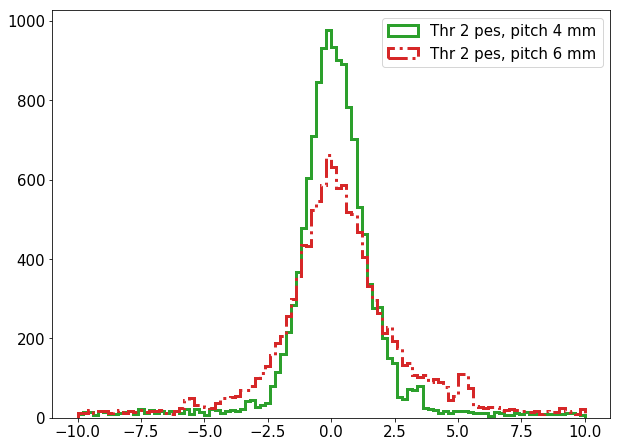

In [7]:
colors = [blue, green, red, purple, brown]
linestyle = ['-', '-.', ':','-','--']

### Threshold = 2 pitch 4 mm
valid1 = reco_x1_thr2 < 1.e9
valid2 = reco_x2_thr2 < 1.e9

rad_true1_thr2 = np.sqrt(true_x1_thr2 * true_x1_thr2 + true_y1_thr2 * true_y1_thr2) 
rad_reco1_thr2 = np.sqrt(reco_x1_thr2 * reco_x1_thr2 + reco_y1_thr2 * reco_y1_thr2)
rad_true2_thr2 = np.sqrt(true_x2_thr2 * true_x2_thr2 + true_y2_thr2 * true_y2_thr2) 
rad_reco2_thr2 = np.sqrt(reco_x2_thr2 * reco_x2_thr2 + reco_y2_thr2 * reco_y2_thr2)

diff_rad1_thr2 = rad_reco1_thr2[valid1] - rad_true1_thr2[valid1]
diff_rad2_thr2 = rad_reco2_thr2[valid2] - rad_true1_thr2[valid2]
diff_rad_thr2 = np.concatenate((diff_rad1_thr2, diff_rad2_thr2))

### Threshold = 2 pitch 6 mm
valid1 = reco_x1_thr2_6mm < 1.e9
valid2 = reco_x2_thr2_6mm < 1.e9

rad_true1_thr2_6mm = np.sqrt(true_x1_thr2_6mm * true_x1_thr2_6mm + true_y1_thr2_6mm * true_y1_thr2_6mm) 
rad_reco1_thr2_6mm = np.sqrt(reco_x1_thr2_6mm * reco_x1_thr2_6mm + reco_y1_thr2_6mm * reco_y1_thr2_6mm)
rad_true2_thr2_6mm = np.sqrt(true_x2_thr2_6mm * true_x2_thr2_6mm + true_y2_thr2_6mm * true_y2_thr2_6mm) 
rad_reco2_thr2_6mm = np.sqrt(reco_x2_thr2_6mm * reco_x2_thr2_6mm + reco_y2_thr2_6mm * reco_y2_thr2_6mm)

diff_rad1_thr2_6mm = rad_reco1_thr2_6mm[valid1] - rad_true1_thr2_6mm[valid1]
diff_rad2_thr2_6mm = rad_reco2_thr2_6mm[valid2] - rad_true1_thr2_6mm[valid2]
diff_rad_thr2_6mm = np.concatenate((diff_rad1_thr2_6mm, diff_rad2_thr2_6mm))


plot_range = (-10, 10)
bins = 100

h0 = plt.hist(diff_rad_thr2, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Thr 2 pes, pitch 4 mm', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_rad_thr2_6mm, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Thr 2 pes, pitch 6 mm', linewidth=3.0, linestyle=linestyle[1])
plt.legend()

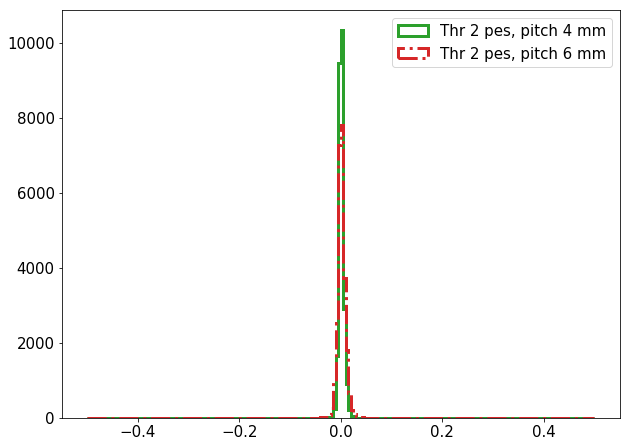

In [38]:
### Threshold 2 pes, pitch 4 mm
valid1 = reco_x1_thr2 < 1.e9
valid2 = reco_x2_thr2 < 1.e9
phi_true1_thr2 = np.arctan2(true_y1_thr2, true_x1_thr2) 
phi_reco1_thr2 = np.arctan2(reco_y1_thr2, reco_x1_thr2) 
phi_true2_thr2 = np.arctan2(true_y2_thr2, true_x2_thr2) 
phi_reco2_thr2 = np.arctan2(reco_y2_thr2, reco_x2_thr2) 

diff_phi1_thr2 = phi_reco1_thr2[valid1] - phi_true1_thr2[valid1]
diff_phi2_thr2 = phi_reco2_thr2[valid2] - phi_true2_thr2[valid2]
diff_phi_thr2 = np.concatenate((diff_phi1_thr2, diff_phi2_thr2))

### Threshold 2 pes, pitch 6 mm

valid1 = reco_x1_thr2_6mm < 1.e9
valid2 = reco_x2_thr2_6mm  < 1.e9
phi_true1_thr2_6mm = np.arctan2(true_y1_thr2_6mm, true_x1_thr2_6mm) 
phi_reco1_thr2_6mm = np.arctan2(reco_y1_thr2_6mm, reco_x1_thr2_6mm) 
phi_true2_thr2_6mm = np.arctan2(true_y2_thr2_6mm, true_x2_thr2_6mm) 
phi_reco2_thr2_6mm = np.arctan2(reco_y2_thr2_6mm, reco_x2_thr2_6mm) 

diff_phi1_thr2_6mm = phi_reco1_thr2_6mm[valid1] - phi_true1_thr2_6mm[valid1]
diff_phi2_thr2_6mm = phi_reco2_thr2_6mm[valid2] - phi_true2_thr2_6mm[valid2]
diff_phi_thr2_6mm = np.concatenate((diff_phi1_thr2_6mm, diff_phi2_thr2_6mm))


plot_range = (-0.5, 0.5)
bins = 200

h4 = plt.hist(diff_phi_thr2, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Thr 2 pes, pitch 4 mm', linewidth=3.0, linestyle=linestyle[0])
h6 = plt.hist(diff_phi_thr2_6mm, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Thr 2 pes, pitch 6 mm', linewidth=3.0, linestyle=linestyle[1])
plt.legend()

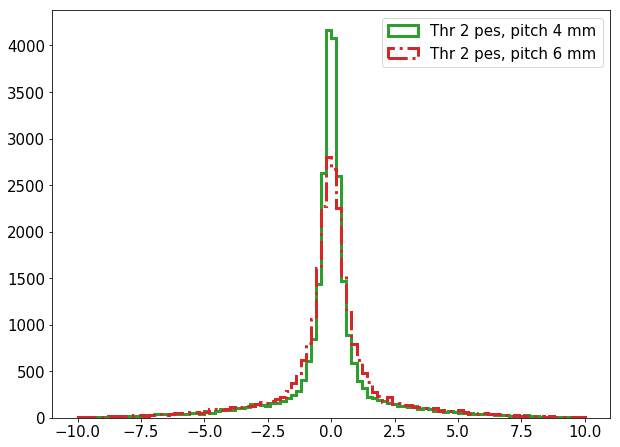

In [19]:
### Threshold 2 pes, pitch 4 mm

valid1 = reco_z1_thr2 < 1.e9
valid2 = reco_z2_thr2 < 1.e9
diff_z1_thr2 = reco_z1_thr2[valid1] - true_z1_thr2[valid1]
diff_z2_thr2 = reco_z2_thr2[valid2] - true_z2_thr2[valid2]
diff_z_thr2 = np.concatenate((diff_z1_thr2, diff_z2_thr2))

### Threshold 2 pes, pitch 6 mm

valid1 = reco_z1_thr2_6mm < 1.e9
valid2 = reco_z2_thr2_6mm < 1.e9
diff_z1_thr2_6mm = reco_z1_thr2_6mm[valid1] - true_z1_thr2_6mm[valid1]
diff_z2_thr2_6mm = reco_z2_thr2_6mm[valid2] - true_z2_thr2_6mm[valid2]
diff_z_thr2_6mm = np.concatenate((diff_z1_thr2_6mm, diff_z2_thr2_6mm))

plot_range = (-10, 10)
bins = 100

h0 = plt.hist(diff_z_thr2, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Thr 2 pes, pitch 4 mm', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_z_thr2_6mm, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Thr 2 pes, pitch 6 mm', linewidth=3.0, linestyle=linestyle[1])
plt.legend()

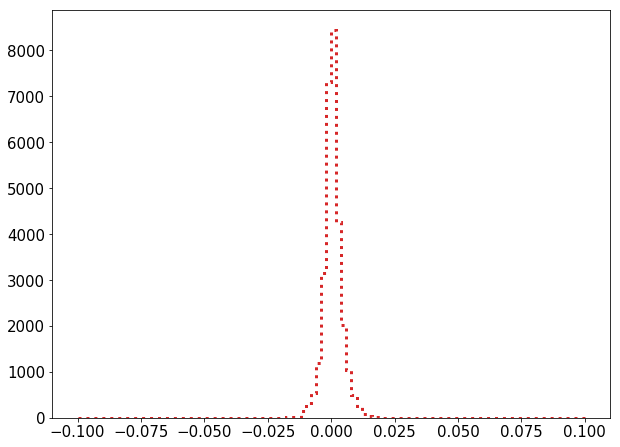

In [32]:
valid1 = reco_x1 < 1.e9
valid2 = reco_x2 < 1.e9
phi_true1 = np.arctan2(true_y1, true_x1) 
phi_reco1 = np.arctan2(reco_y1, reco_x1) 
phi_true2 = np.arctan2(true_y2, true_x2) 
phi_reco2 = np.arctan2(reco_y2, reco_x2) 

diff_phi1 = phi_reco1[valid1] - phi_true1[valid1]
diff_phi2 = phi_reco2[valid2] - phi_true2[valid2]
diff_phi = np.concatenate((diff_phi1, diff_phi2))

valid1 = reco_x1_thr2 < 1.e9
valid2 = reco_x2_thr2  < 1.e9
phi_true1_thr2 = np.arctan2(true_y1_thr2, true_x1_thr2) 
phi_reco1_thr2 = np.arctan2(reco_y1_thr2, reco_x1_thr2) 
phi_true2_thr2 = np.arctan2(true_y2_thr2, true_x2_thr2) 
phi_reco2_thr2 = np.arctan2(reco_y2_thr2, reco_x2_thr2) 

diff_phi1_thr2 = phi_reco1_thr2[valid1] - phi_true1_thr2[valid1]
diff_phi2_thr2 = phi_reco2_thr2[valid2] - phi_true2_thr2[valid2]
diff_phi_thr2 = np.concatenate((diff_phi1_thr2, diff_phi2_thr2))


valid1 = reco_x1_thr3 < 1.e9
valid2 = reco_x2_thr3  < 1.e9
phi_true1_thr3 = np.arctan2(true_y1_thr3, true_x1_thr3) 
phi_reco1_thr3 = np.arctan2(reco_y1_thr3, reco_x1_thr3) 
phi_true2_thr3 = np.arctan2(true_y2_thr3, true_x2_thr3) 
phi_reco2_thr3 = np.arctan2(reco_y2_thr3, reco_x2_thr3) 

diff_phi1_thr3 = phi_reco1_thr3[valid1] - phi_true1_thr3[valid1]
diff_phi2_thr3 = phi_reco2_thr3[valid2] - phi_true2_thr3[valid2]
diff_phi_thr3 = np.concatenate((diff_phi1_thr3, diff_phi2_thr3))

plot_range = (-0.1, 0.1)
bins = 100

#h0 = plt.hist(diff_phi, bins=bins, color=colors[0], range=plot_range, histtype='step', 
#         stacked=True, fill=False, label='No threshold', linewidth=3.0, linestyle=linestyle[0])
#h2 = plt.hist(diff_phi_thr2, bins=bins, color=colors[1], range=plot_range, histtype='step', 
#         stacked=True, fill=False, label='Threshold = 2 pe', linewidth=3.0, linestyle=linestyle[1])
h3 = plt.hist(diff_phi_thr3, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Threshold = 3 pe', linewidth=3.0, linestyle=linestyle[2])


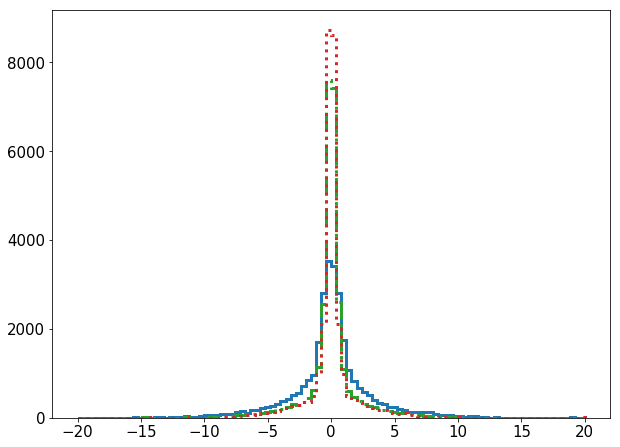

In [33]:
valid1 = reco_z1 < 1.e9
valid2 = reco_z2 < 1.e9
diff_z1 = reco_z1[valid1] - true_z1[valid1]
diff_z2 = reco_z2[valid2] - true_z2[valid2]
diff_z = np.concatenate((diff_z1, diff_z2))

valid1 = reco_z1_thr2 < 1.e9
valid2 = reco_z2_thr2 < 1.e9
diff_z1_thr2 = reco_z1_thr2[valid1] - true_z1_thr2[valid1]
diff_z2_thr2 = reco_z2_thr2[valid2] - true_z2_thr2[valid2]
diff_z_thr2 = np.concatenate((diff_z1_thr2, diff_z2_thr2))

valid1 = reco_z1_thr3 < 1.e9
valid2 = reco_z2_thr3 < 1.e9
diff_z1_thr3 = reco_z1_thr3[valid1] - true_z1_thr3[valid1]
diff_z2_thr3 = reco_z2_thr3[valid2] - true_z2_thr3[valid2]
diff_z_thr3 = np.concatenate((diff_z1_thr3, diff_z2_thr3))

plot_range = (-20, 20)
bins = 100

h0 = plt.hist(diff_z, bins=bins, color=colors[0], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='No threshold', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_z_thr2, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Threshold = 2 pe', linewidth=3.0, linestyle=linestyle[1])
h3 = plt.hist(diff_z_thr3, bins=bins, color=colors[2], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Threshold = 3 pe', linewidth=3.0, linestyle=linestyle[2])

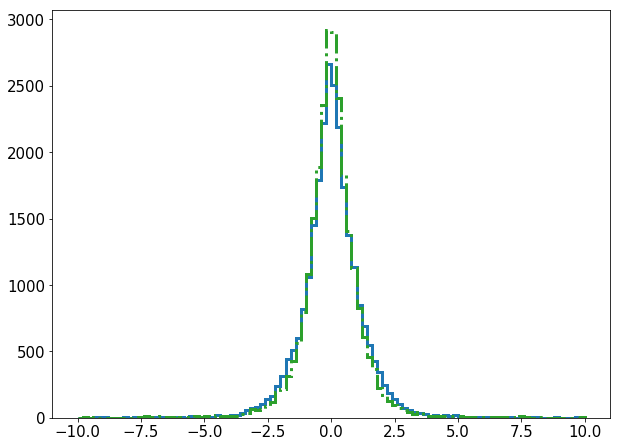

In [48]:
valid1 = reco_x1 < 1.e9
valid2 = reco_x2 < 1.e9
diff_x1 = reco_x1[valid1] - true_x1[valid1]
diff_x2 = reco_x2[valid2] - true_x2[valid2]
diff_x = np.concatenate((diff_x1, diff_x2))

valid1_thr2 = reco_x1_thr2 < 1.e9
valid2_thr2 = reco_x2_thr2 < 1.e9
diff_x1_thr2 = reco_x1_thr2[valid1] - true_x1_thr2[valid1]
diff_x2_thr2 = reco_x2_thr2[valid2] - true_x2_thr2[valid2]
diff_x_thr2 = np.concatenate((diff_x1_thr2, diff_x2_thr2))


plot_range = (-10, 10)
bins = 100

h0 = plt.hist(diff_x, bins=bins, color=colors[0], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='No threshold', linewidth=3.0, linestyle=linestyle[0])
h2 = plt.hist(diff_x_thr2, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Threshold = 2 pe', linewidth=3.0, linestyle=linestyle[1])
h3 = plt.hist(diff_x_thr3, bins=bins, color=colors[1], range=plot_range, histtype='step', 
         stacked=True, fill=False, label='Threshold = 2 pe', linewidth=3.0, linestyle=linestyle[1])

In [37]:
np.where(reco_x1_thr1 - true_x1_thr1 ==0)

(array([     0,      1,      2, ..., 450384, 450385, 450386]),)

### Using only the internal SiPMs

[  2.91619940e+03  -1.44647201e-02   6.19275434e-01]
[  5.30276732e+01   1.17088462e-02   1.44757616e-02]
Mean = -0.014464720086997193 mm
FWHM = 1.4552972702362534 mm


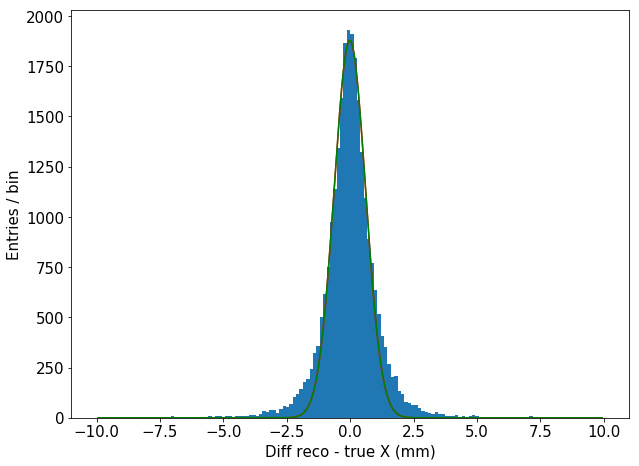

In [50]:
valid1 = reco_x1_int < 1.e9
valid2 = reco_x2_int < 1.e9
diff_x1 = reco_x1_int[valid1] - true_x1[valid1]
diff_x2 = reco_x2_int[valid2] - true_x2[valid2]
diff_x = np.concatenate((diff_x1, diff_x2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_x, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true X (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  2.92950342e+03   1.55563429e-03   6.16566275e-01]
[  5.79640939e+01   1.27200557e-02   1.56621041e-02]
Mean = 0.0015556342929701527 mm
FWHM = 0.6165662748281338 mm


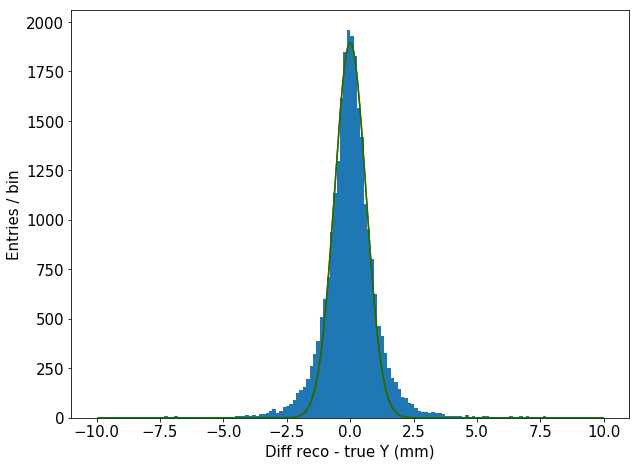

In [18]:
valid1 = reco_y1_int < 1.e9
valid2 = reco_y2_int < 1.e9
diff_y1 = reco_y1_int[valid1] - true_y1[valid1]
diff_y2 = reco_y2_int[valid2] - true_y2[valid2]
diff_y = np.concatenate((diff_y1, diff_y2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_y, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true Y (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  4.06702811e+03   9.98426014e-03   7.86859014e-01]
[  4.88845706e+01   8.67630437e-03   1.24863780e-02]
Mean = 0.009984260143965177 mm
FWHM = 0.7868590135581605 mm


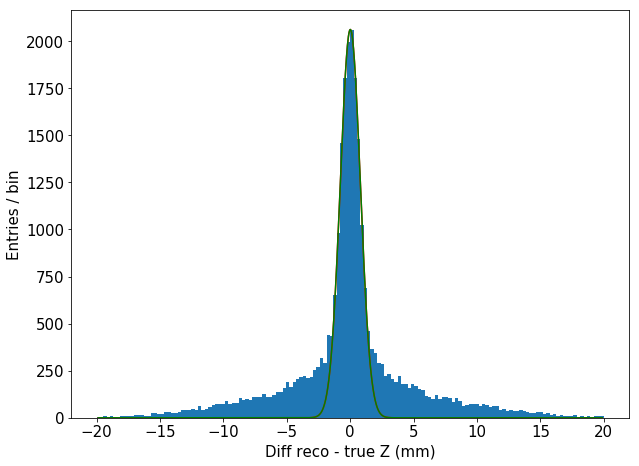

In [20]:
valid1 = reco_z1_int < 1.e9
valid2 = reco_z2_int < 1.e9
diff_z1 = reco_z1_int[valid1] - true_z1[valid1]
diff_z2 = reco_z2_int[valid2] - true_z2[valid2]
diff_z = np.concatenate((diff_z1, diff_z2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_z, bins=bins, range=(-20,20.), new_figure=False)
plt.xlabel('Diff reco - true Z (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  2.45392817e+03   5.91679280e-02   1.01635289e+00]
[  7.85432726e+01   2.11475397e-02   4.08485649e-02]
Mean = 0.05916792804959011 mm
FWHM = 2.388429299532693 mm


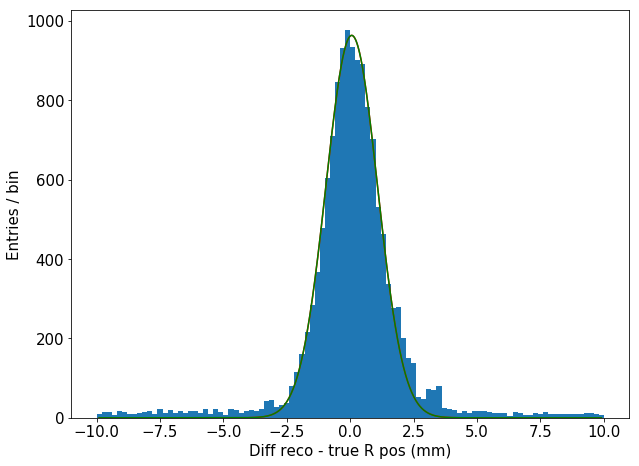

In [29]:
rad_int = 100.
rad_ext = 130.
#average_rad = (rad_int + rad_ext)/2.

valid1 = reco_x1_int < 1.e9
valid2 = reco_x2_int < 1.e9
rad_true1 = np.sqrt(true_x1 * true_x1 + true_y1 * true_y1) 
rad_reco1_int = np.sqrt(reco_x1_int * reco_x1_int + reco_y1_int * reco_y1_int)
rad_true2 = np.sqrt(true_x2 * true_x2 + true_y2 * true_y2) 
rad_reco2_int = np.sqrt(reco_x2_int * reco_x2_int + reco_y2_int * reco_y2_int)

diff_rad1 = rad_reco1_int[valid1] - rad_true1[valid1]
diff_rad2 = rad_reco2_int[valid2] - rad_true1[valid2]
diff_rad = np.concatenate((diff_rad1, diff_rad2))
bins = 100
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_rad, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true R pos (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  2.41638124e+01   1.42248503e-04   3.57430284e-03]
[  3.09269681e-01   5.28239425e-05   5.28239397e-05]
Mean = 0.00014224850300865292 rad, 0.008150238864449804 degree
FWHM = 0.00839961167628819 rad, 0.48126229860011993 degree


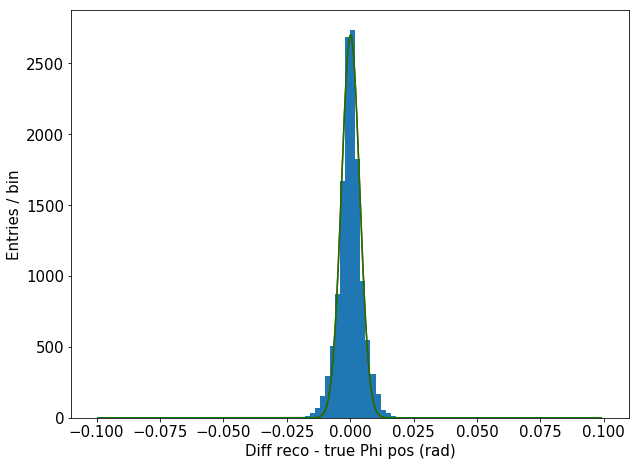

In [38]:
valid1 = reco_x1_int < 1.e9
valid2 = reco_x2_int < 1.e9
phi_true1 = np.arctan2(true_y1, true_x1) 
phi_reco1_int = np.arctan2(reco_y1_int, reco_x1_int) 
phi_true2 = np.arctan2(true_y2, true_x2) 
phi_reco2_int = np.arctan2(reco_y2_int, reco_x2_int) 

diff_phi1 = phi_reco1_int[valid1] - phi_true1[valid1]
diff_phi2 = phi_reco2_int[valid2] - phi_true1[valid2]
diff_phi = np.concatenate((diff_phi1, diff_phi2))
bins = 100
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_phi, bins=bins, range=(-0.1,.1), new_figure=False)
plt.xlabel('Diff reco - true Phi pos (rad)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} rad, {} degree'.format(f.values[1], f.values[1]*180/np.pi))
print('FWHM = {} rad, {} degree'.format(f.values[2]*2.35, f.values[2]*180/np.pi * 2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

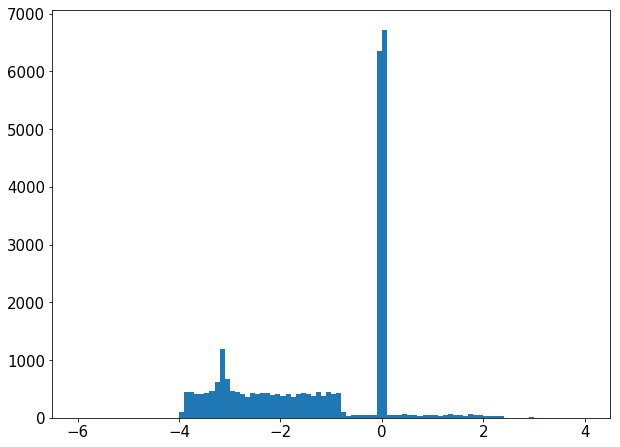

In [42]:
h = hist(diff_phi, bins=bins, range=(-6, 4))

### Using only external SiPMs

[  3.32780415e+03  -3.55341567e-03   1.21200752e+00]
[  1.62367577e+02   3.10542015e-02   7.08331510e-02]
Mean = -0.003553415668565898 mm
FWHM = 1.2120075219190531 mm


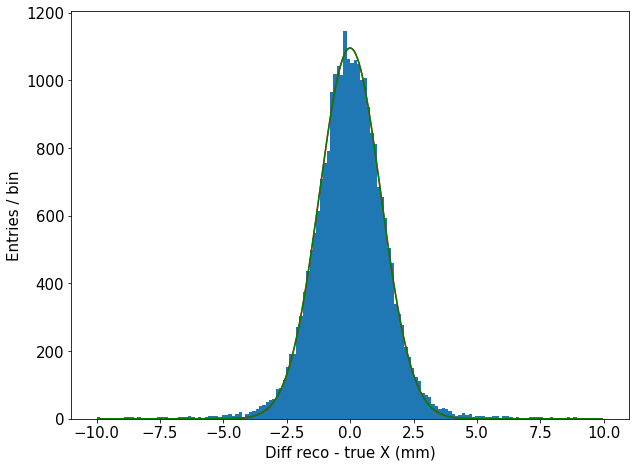

In [21]:
valid1 = reco_x1_ext < 1.e9
valid2 = reco_x2_ext < 1.e9
diff_x1 = reco_x1_ext[valid1] - true_x1[valid1]
diff_x2 = reco_x2_ext[valid2] - true_x2[valid2]
diff_x = np.concatenate((diff_x1, diff_x2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_x, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true X (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  3.22065171e+03  -1.96214901e-02   1.12338385e+00]
[  9.11020292e+01   1.82444131e-02   3.88852110e-02]
Mean = -0.019621490108978158 mm
FWHM = 1.123383851424882 mm


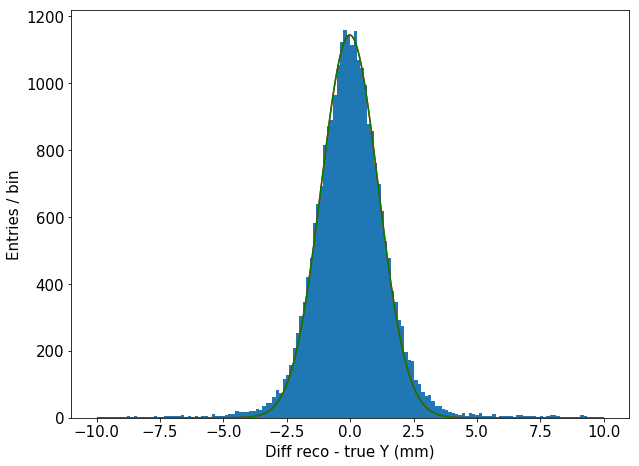

In [22]:
valid1 = reco_y1_ext < 1.e9
valid2 = reco_y2_ext < 1.e9
diff_y1 = reco_y1_ext[valid1] - true_y1[valid1]
diff_y2 = reco_y2_ext[valid2] - true_y2[valid2]
diff_y = np.concatenate((diff_y1, diff_y2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_y, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true Y (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  4.67645544e+03  -2.06074425e-01   2.40758798e+00]
[  2.45910762e+02   2.65958094e-02   1.33542939e-01]
Mean = -0.20607442548836558 mm
FWHM = 2.4075879830770304 mm


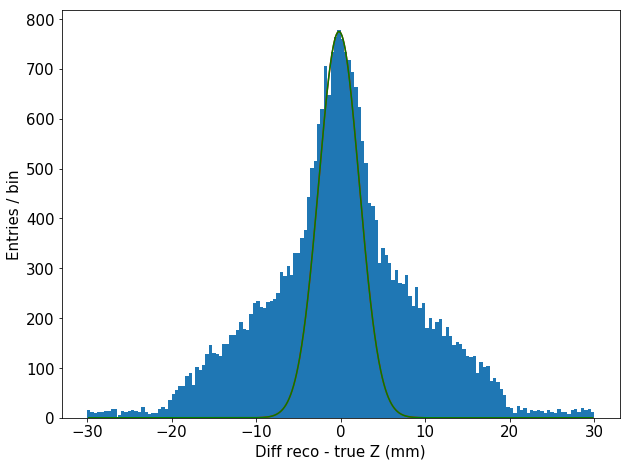

In [46]:
valid1 = reco_z1_ext < 1.e9
valid2 = reco_z2_ext < 1.e9
diff_z1 = reco_z1_ext[valid1] - true_z1[valid1]
diff_z2 = reco_z2_ext[valid2] - true_z2[valid2]
diff_z = np.concatenate((diff_z1, diff_z2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_z, bins=bins, range=(-30,30.), new_figure=False)
plt.xlabel('Diff reco - true Z (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  2.45392817e+03   5.91679280e-02   1.01635289e+00]
[  7.85432726e+01   2.11475397e-02   4.08485649e-02]
Mean = 0.05916792804959011 mm
FWHM = 2.388429299532693 mm


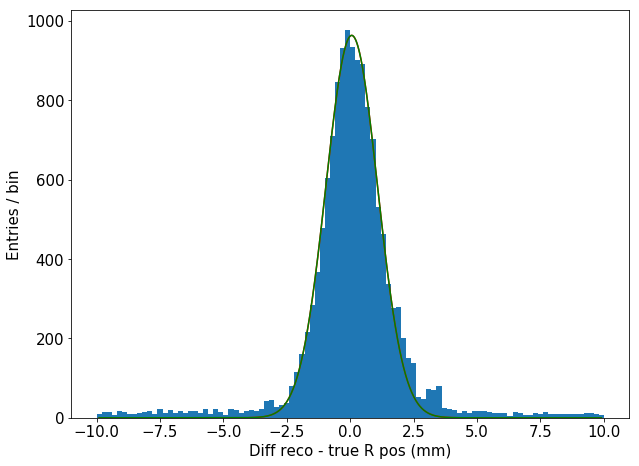

In [43]:
valid1 = reco_x1_ext < 1.e9
valid2 = reco_x2_ext < 1.e9
rad_true1 = np.sqrt(true_x1 * true_x1 + true_y1 * true_y1) 
rad_reco1_ext = np.sqrt(reco_x1_ext * reco_x1_ext + reco_y1_ext * reco_y1_ext)
rad_true2 = np.sqrt(true_x2 * true_x2 + true_y2 * true_y2) 
rad_reco2_ext = np.sqrt(reco_x2_ext * reco_x2_ext + reco_y2_ext * reco_y2_ext)

diff_rad1 = rad_reco1_ext[valid1] - rad_true1[valid1]
diff_rad2 = rad_reco2_ext[valid2] - rad_true1[valid2]
diff_rad = np.concatenate((diff_rad1, diff_rad2))
bins = 100
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_rad, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true R pos (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  2.55224398e+01   5.50269761e-03   9.83935665e-03]
[  1.22572318e-01   5.45640278e-05   5.45640294e-05]
Mean = 0.005502697606771171 rad, 0.31528134880472675 degree
FWHM = 0.023122488133593397 rad, 1.3248209818962298 degree


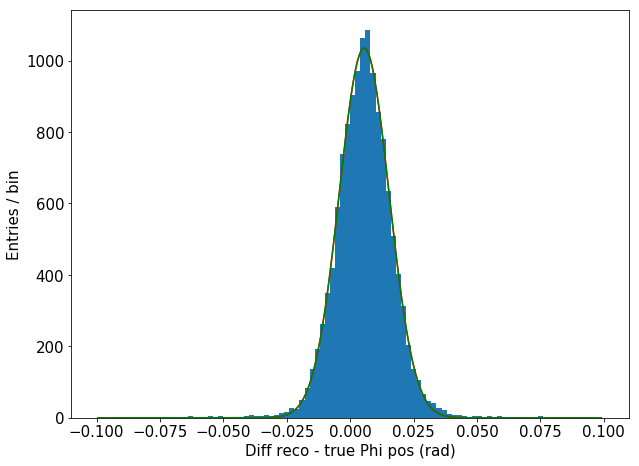

In [44]:
valid1 = reco_x1_int < 1.e9
valid2 = reco_x2_int < 1.e9
phi_true1 = np.arctan2(true_y1, true_x1) 
phi_reco1_ext = np.arctan2(reco_y1_ext, reco_x1_ext) 
phi_true2 = np.arctan2(true_y2, true_x2) 
phi_reco2_ext = np.arctan2(reco_y2_ext, reco_x2_ext) 

diff_phi1 = phi_reco1_ext[valid1] - phi_true1[valid1]
diff_phi2 = phi_reco2_ext[valid2] - phi_true1[valid2]
diff_phi = np.concatenate((diff_phi1, diff_phi2))
bins = 100
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_phi, bins=bins, range=(-0.1,.1), new_figure=False)
plt.xlabel('Diff reco - true Phi pos (rad)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} rad, {} degree'.format(f.values[1], f.values[1]*180/np.pi))
print('FWHM = {} rad, {} degree'.format(f.values[2]*2.35, f.values[2]*180/np.pi * 2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

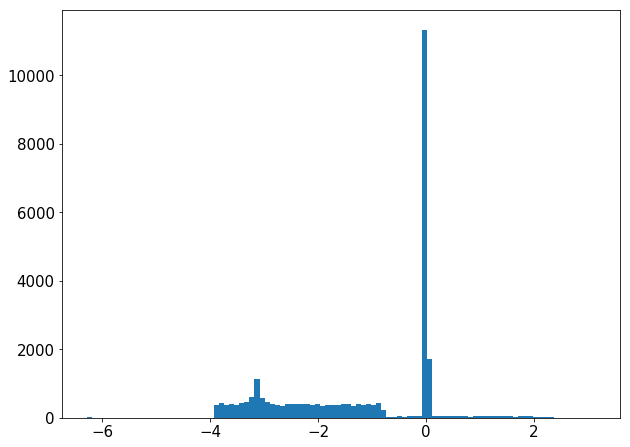

In [45]:
h = hist(diff_phi, bins=bins)

### Using both

[  3.16555380e+03  -1.46390721e-02   6.60191452e-01]
[  5.67057511e+01   1.18563093e-02   1.53902698e-02]
Mean = -0.014639072118214622 mm
FWHM = 1.5514499118323917 mm


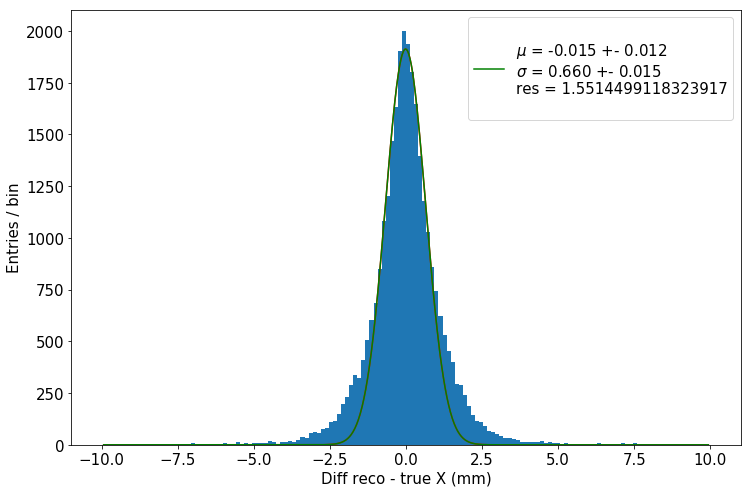

In [18]:
valid1 = reco_x1 < 1.e9
valid2 = reco_x2 < 1.e9
diff_x1 = reco_x1[valid1] - true_x1[valid1]
diff_x2 = reco_x2[valid2] - true_x2[valid2]
diff_x = np.concatenate((diff_x1, diff_x2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_x, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true X (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))
legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

[  2.81068212e+03   8.08676114e-02   1.00614036e+00]
[  2.71509358e+01   1.12228420e-02   1.12228415e-02]
Mean = 0.0808676114406523 mm
FWHM = 2.3644298438344205 mm


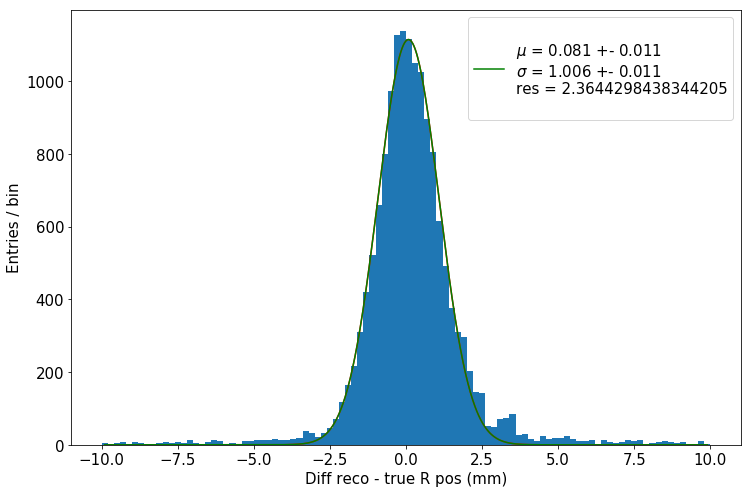

In [38]:
#valid1 = reco_x1 < 1.e9
#valid2 = reco_x2 < 1.e9
#rad_true1 = np.sqrt(true_x1 * true_x1 + true_y1 * true_y1) 
#rad_reco1 = np.sqrt(reco_x1 * reco_x1 + reco_y1 * reco_y1)
#rad_true2 = np.sqrt(true_x2 * true_x2 + true_y2 * true_y2) 
#rad_reco2 = np.sqrt(reco_x2 * reco_x2 + reco_y2 * reco_y2)

valid1 = reco_x1_thr3 < 1.e9
valid2 = reco_x2_thr3 < 1.e9
rad_true1 = np.sqrt(true_x1_thr3 * true_x1_thr3 + true_y1_thr3 * true_y1_thr3) 
rad_reco1 = np.sqrt(reco_x1_thr3 * reco_x1_thr3 + reco_y1_thr3 * reco_y1_thr3)
rad_true2 = np.sqrt(true_x2_thr3 * true_x2_thr3 + true_y2_thr3 * true_y2_thr3) 
rad_reco2 = np.sqrt(reco_x2_thr3 * reco_x2_thr3 + reco_y2_thr3 * reco_y2_thr3)

diff_rad1 = rad_reco1[valid1] - rad_true1[valid1]
diff_rad2 = rad_reco2[valid2] - rad_true1[valid2]
diff_rad = np.concatenate((diff_rad1, diff_rad2))
bins = 100
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_rad, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true R pos (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-10, 10))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

[  1.32741172e+03   2.05279789e-02   1.41018266e-01]
[  3.35492046e+01   4.11547217e-03   4.11547242e-03]
Mean = 0.020527978881906512 rad, 0.020527978881906512 degree
FWHM = 0.33139292442527657 rad, 0.33139292442527657 degree


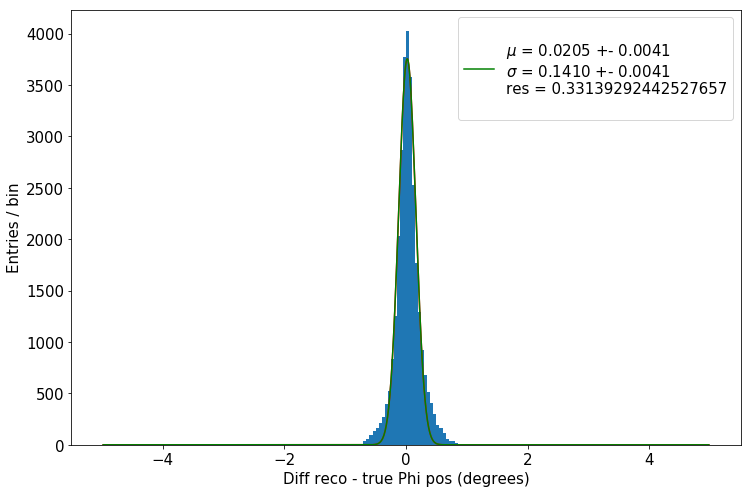

In [39]:
#valid1 = reco_x1 < 1.e9
#valid2 = reco_x2 < 1.e9
#phi_true1 = np.arctan2(true_y1, true_x1) 
#phi_reco1 = np.arctan2(reco_y1, reco_x1) 
#phi_true2 = np.arctan2(true_y2, true_x2) 
#phi_reco2 = np.arctan2(reco_y2, reco_x2) 

valid1 = reco_x1_thr3 < 1.e9
valid2 = reco_x2_thr3 < 1.e9
phi_true1 = np.arctan2(true_y1_thr3, true_x1_thr3) 
phi_reco1 = np.arctan2(reco_y1_thr3, reco_x1_thr3) 
phi_true2 = np.arctan2(true_y2_thr3, true_x2_thr3) 
phi_reco2 = np.arctan2(reco_y2_thr3, reco_x2_thr3) 

diff_phi1 = phi_reco1[valid1] - phi_true1[valid1]
diff_phi2 = phi_reco2[valid2] - phi_true2[valid2]
diff_phi = np.concatenate((diff_phi1, diff_phi2))
bins = 200
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_phi*180/np.pi, bins=bins, range=(-5,5), new_figure=False)
plt.xlabel('Diff reco - true Phi pos (degrees)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} rad, {} degree'.format(f.values[1], f.values[1]))
print('FWHM = {} rad, {} degree'.format(f.values[2]*2.35, f.values[2] * 2.35))

legend = gtext(f.values[1:],f.errors[1:])
xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

In [40]:
### FWHM in arc
factor = 180/np.pi
print(np.sin(f.values[2]/factor)*100*2.35)
print(np.sin(f.values[2]/factor)*130*2.35)

0.578389180955
0.751905935241


[  2.48434090e+03  -6.41842768e-04   8.19611447e-01]
[  4.12864335e+01   1.14190066e-02   1.78089394e-02]
Mean = -0.0006418427680780248 mm
FWHM = 1.9260869015330773 mm


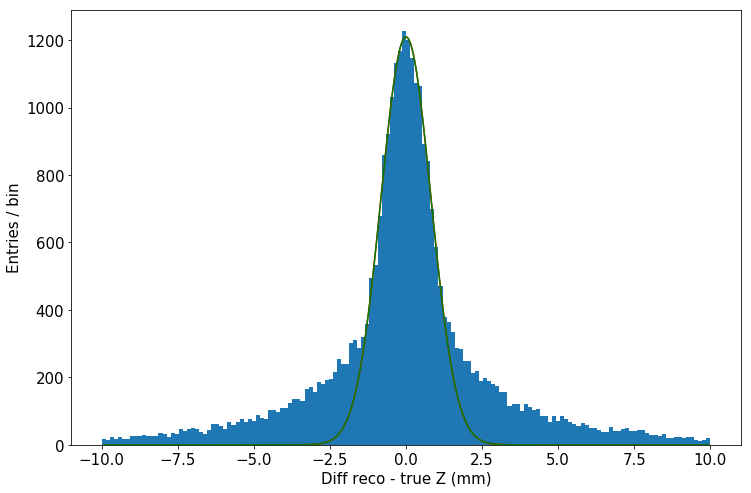

In [31]:
valid1 = reco_z1 < 1.e9
valid2 = reco_z2 < 1.e9
diff_z1 = reco_z1[valid1] - true_z1[valid1]
diff_z2 = reco_z2[valid2] - true_z2[valid2]
diff_z = np.concatenate((diff_z1, diff_z2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_z, bins=bins, range=(-10,10.), new_figure=False)
plt.xlabel('Diff reco - true Z (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-1, 1))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-')

[  2.02446869e+03  -4.73795865e-04   2.58301709e-01]
[  9.32643283e+01   1.37360994e-02   1.37488290e-02]
Mean = -0.0004737958649568619 mm
FWHM = 0.6070090157478713 mm


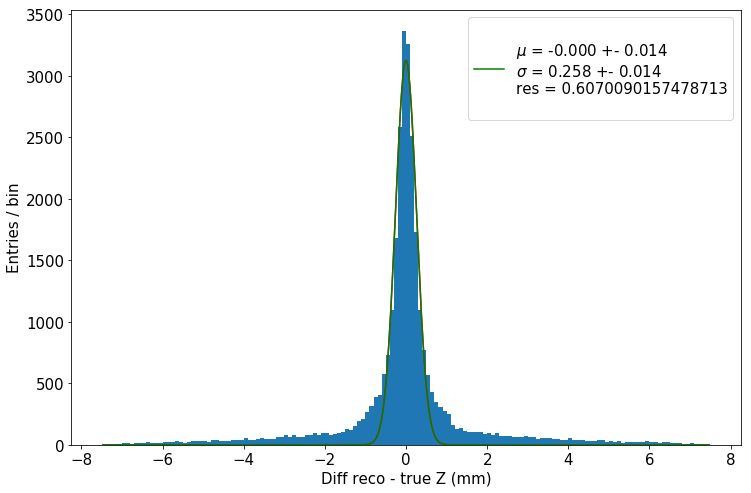

In [37]:
valid1 = reco_z1_thr3 < 1.e9
valid2 = reco_z2_thr3 < 1.e9
diff_z1 = reco_z1_thr3[valid1] - true_z1_thr3[valid1]
diff_z2 = reco_z2_thr3[valid2] - true_z2_thr3[valid2]
diff_z = np.concatenate((diff_z1, diff_z2))
bins = 150
#h1 = hist(diff_x, bins=bins, range=(-10, 10))
y, x, _ = hist(diff_z, bins=bins, range=(-7.5,7.5), new_figure=False)
plt.xlabel('Diff reco - true Z (mm)')
plt.ylabel('Entries / bin')
seed = 5, 0, 5
f    = fitf.fit(gauss, x, y, seed, fit_range=(-0.8, 0.8))
print(f.values)
print(f.errors)
#print(f.chi2)
print('Mean = {} mm'.format(f.values[1]))
print('FWHM = {} mm'.format(f.values[2]*2.35))

legend = gtext(f.values[1:],f.errors[1:])

xmin = min(x)
xmax = max(x)
mx = np.linspace(xmin, xmax, 1000)
plt.plot(mx, f.fn(mx), 'r')
plt.plot(mx, gauss(mx, f.values[0], f.values[1], f.values[2]), 'g-', label=legend)
plt.legend(loc=1)

In [42]:
true_x1_thr2_6mm = true_x2_thr2_6mm = true_y1_thr2_6mm = true_y2_thr2_6mm = true_z1_thr2_6mm = true_z2_thr2_6mm = []
reco_x1_thr2_6mm = reco_x2_thr2_6mm = reco_y1_thr2_6mm = reco_y2_thr2_6mm = reco_z1_thr2_6mm = reco_z2_thr2_6mm = []
events = []

file_base = '/Users/paola/PETALO/analysis/observables/test/full_ring_depth3cm_pitch6mm_phot_reco_{0}_{1}_0.npz'

bunch = 1
for f in range(0, 20, bunch):
    filename = file_base.format(f, bunch)
    try:
        d = np.load(filename)
    except:
        print('File {} not found'.format(filename))
        continue 
            
    true_x1_thr2_6mm = np.concatenate((true_x1_thr2_6mm, d['a_true_x1']))
    true_y1_thr2_6mm = np.concatenate((true_y1_thr2_6mm, d['a_true_y1']))
    true_z1_thr2_6mm = np.concatenate((true_z1_thr2_6mm, d['a_true_z1']))   
    true_x2_thr2_6mm = np.concatenate((true_x2_thr2_6mm, d['a_true_x2']))
    true_y2_thr2_6mm = np.concatenate((true_y2_thr2_6mm, d['a_true_y2']))
    true_z2_thr2_6mm = np.concatenate((true_z2_thr2_6mm, d['a_true_z2']))
            
    reco_x1_thr2_6mm = np.concatenate((reco_x1_thr2_6mm, d['a_reco_x1']))
    reco_y1_thr2_6mm = np.concatenate((reco_y1_thr2_6mm, d['a_reco_y1']))
    reco_z1_thr2_6mm = np.concatenate((reco_z1_thr2_6mm, d['a_reco_z1']))   
    reco_x2_thr2_6mm = np.concatenate((reco_x2_thr2_6mm, d['a_reco_x2']))
    reco_y2_thr2_6mm = np.concatenate((reco_y2_thr2_6mm, d['a_reco_y2']))
    reco_z2_thr2_6mm = np.concatenate((reco_z2_thr2_6mm, d['a_reco_z2']))
    
    events = np.concatenate((events, d['a_events']))
    
    
true_x1_thr2_6mm = np.array(true_x1_thr2_6mm)
true_x2_thr2_6mm = np.array(true_x2_thr2_6mm)
true_y1_thr2_6mm = np.array(true_y1_thr2_6mm)
true_y2_thr2_6mm = np.array(true_y2_thr2_6mm)
true_z1_thr2_6mm = np.array(true_z1_thr2_6mm)
true_z2_thr2_6mm = np.array(true_z2_thr2_6mm)


reco_x1_thr2_6mm = np.array(reco_x1_thr2_6mm)
reco_x2_thr2_6mm = np.array(reco_x2_thr2_6mm)
reco_y1_thr2_6mm = np.array(reco_y1_thr2_6mm)
reco_y2_thr2_6mm = np.array(reco_y2_thr2_6mm)
reco_z1_thr2_6mm = np.array(reco_z1_thr2_6mm)
reco_z2_thr2_6mm = np.array(reco_z2_thr2_6mm)

events = np.array(events)

In [55]:
valid1 = reco_x1_thr2_6mm < 1.e9
valid2 = reco_x2_thr2_6mm < 1.e9
phi_true1 = np.arctan2(true_y1_thr2_6mm, true_x1_thr2_6mm) 
phi_reco1 = np.arctan2(reco_y1_thr2_6mm, reco_x1_thr2_6mm) 
phi_true2 = np.arctan2(true_y2_thr2_6mm, true_x2_thr2_6mm) 
phi_reco2 = np.arctan2(reco_y2_thr2_6mm, reco_x2_thr2_6mm) 

diff_phi1 = phi_reco1[valid1] - phi_true1[valid1]
diff_phi2 = phi_reco2[valid2] - phi_true2[valid2]
diff_phi = np.concatenate((diff_phi1, diff_phi2))

np.where(diff_phi1 < -3.)

(array([   4,    9,   14,   23,   25,   32,   74,   90,   99,  109,  111,
         118,  137,  138,  144,  147,  156,  166,  174,  205,  207,  208,
         212,  219,  224,  236,  245,  255,  271,  288,  316,  345,  351,
         370,  384,  388,  407,  408,  409,  438,  460,  461,  523,  524,
         526,  557,  560,  563,  577,  583,  618,  643,  650,  655,  674,
         678,  712,  719,  748,  749,  757,  759,  765,  800,  808,  817,
         818,  820,  830,  838,  844,  850,  851,  880,  907,  928,  929,
         980,  986,  988, 1017, 1030, 1031, 1054, 1098, 1104, 1130, 1147,
        1153, 1164, 1187, 1201, 1207, 1209, 1219, 1243, 1253, 1259, 1264,
        1276, 1280, 1311, 1324, 1332, 1361, 1386, 1388, 1390, 1419, 1450,
        1460, 1461, 1463, 1513, 1519, 1540, 1546, 1552, 1561, 1580, 1592,
        1600, 1601, 1612, 1640, 1679, 1718, 1754, 1809, 1829, 1865, 1869,
        1874, 1892, 1896, 1923, 1932, 1934, 1935, 1944, 1989, 1993, 2004,
        2016, 2017, 2030, 2040, 2049, 

In [57]:
sel_evt = events[valid1]

In [63]:
len(sel_evt[diff_phi1 < -3.])

328

In [62]:
len(np.where(diff_phi1<-3.)[0])

328

In [64]:
sel_evt[diff_phi1 < -3.]

array([  1.24000000e+02,   2.82000000e+02,   4.03000000e+02,
         6.99000000e+02,   7.82000000e+02,   9.90000000e+02,
         2.25400000e+03,   2.84100000e+03,   3.04900000e+03,
         3.17100000e+03,   3.24800000e+03,   3.45100000e+03,
         4.01500000e+03,   4.03100000e+03,   4.32400000e+03,
         4.39800000e+03,   4.65600000e+03,   5.02900000e+03,
         5.23600000e+03,   6.00500000e+03,   6.05800000e+03,
         6.24000000e+03,   6.37500000e+03,   1.02610000e+04,
         1.04270000e+04,   1.08070000e+04,   1.11420000e+04,
         1.15260000e+04,   1.19870000e+04,   1.25960000e+04,
         1.32750000e+04,   1.42610000e+04,   1.44650000e+04,
         1.51140000e+04,   1.56170000e+04,   1.58070000e+04,
         1.63540000e+04,   1.63600000e+04,   2.00270000e+04,
         2.09540000e+04,   2.15700000e+04,   2.15950000e+04,
         2.36290000e+04,   2.36530000e+04,   2.37050000e+04,
         2.48690000e+04,   2.49270000e+04,   2.50080000e+04,
         2.55050000e+04,

In [69]:
np.where(events == 124)

(array([120]),)

In [78]:
true_x1_thr2_6mm[events == 124]

array([-19.24624947])

In [73]:
true_z1_thr2_6mm[events == 124]

array([-23.90840358])

In [74]:
reco_x1_thr2_6mm[events == 124]

array([ 18.68987469])

In [75]:
reco_y1_thr2_6mm[events == 124]

array([-103.95108054])

In [76]:
reco_z1_thr2_6mm[events == 124]

array([ 20.61169102])